### Questions
1. Which accuracy would we reach I we would use the method of an analytical dictionary lookup?
2. What is the influence of the window size?

From the input files, a dataset is created in the form of a list of pairs (tuples) of input form and output form. Output forms with an underscore (embedded space) are split on the underscore, and both pieces are marked with an
underscore so that a window can be removed if such a piece contaminates it.

In [1]:
# Add the pairs of input and output form of one verse to the dataset

def add_pairs(dataset, words_in, words_out):
   # Split the forms at the underscore, but keep them marked
   words_out = words_out.replace("_", "_ _")
   w_in = words_in.split()
   w_out = words_out.split()
   assert(len(w_in) == len(w_out))
   for i in range(len(w_in)):
      dataset.append((w_in[i], w_out[i]))

# Read the file with input forms and the file with output forms and
# create a dataset in the form of a list of pairs (tuples) of input
# form and output form.

def create_dataset(fname_in, fname_out):
   dataset = []
   with open(fname_in) as f_in, open(fname_out) as f_out:
      for verse_in in f_in:
         verse_out = f_out.readline()
         words_in = verse_in.split("\t")[3].strip()
         words_out = verse_out.split("\t")[3].strip()
         add_pairs(dataset, words_in, words_out)
   return dataset

The dataset requires more preprocessing, but this depends on the window size. A window is a space-separated list of input or output forms from the dataset. We create a list of windows and discard the ones that are not useful. The result is called the working set.

In [2]:
# The working set is the result of moving a sliding window of size w
# over the dataset, where all windows that contain a ketib-qere or an
# underscore (a lexeme with an embedded space) are discarded.
def add_window(ws, window):
   w_in = ' '.join([w[0] for w in window])
   w_out = ' '.join([w[1] for w in window])
   if '*' not in w_in and '_' not in w_out:
      ws.append((w_in, w_out))

def create_working_set(dataset, w):
   ws = []
   n = len(dataset)
   for i in range(n-w+1):
      ds = dataset[i:i+w]
      add_window(ws, ds)
   for i in range(n-w+1, n):
      ds = dataset[i:n] + dataset[0:i+w-n]
      add_window(ws, ds)
   return ws

We create an analytical dictionary, called _anwb_, with an entry for each input form, based on a training set. The input form is the key. The value is the most frequent analysis of this input form.

We further define the accuracy of the anwb for a working set as the fraction of the working set that will be analysed correctly with a lookup in this anwb.

In [3]:
from collections import Counter

def create_anwb(ws):
   anwb = {}
   for entry in Counter(ws).most_common():
      pair, freq = entry
      w_in, w_out = pair
      if w_in not in anwb:
         anwb[w_in] = w_out
   return anwb


def accuracy(ws, anwb):
   n_errors = 0
   for pair in ws:
      w_in, w_out = pair
      if w_in not in anwb or anwb[w_in] != w_out:
         n_errors += 1
   return 1 - n_errors / len(ws)

When interpreting the results, we like to how ambiguous a working set was. We therefore define the rate of ambiguity as follows.

In [4]:
# The rate of ambiguity we define as the number of input forms that
# do not have a unique analysis throughout the dataset, divided by
# the total number of input forms.
def ambiguity(ws):
   pair_counts = Counter(ws)
   input_counts = Counter()
   for p in pair_counts:
      input_counts[p[0]] += pair_counts[p]
   key_counts = Counter([p[0] for p in pair_counts])
   n = 0
   for w in key_counts:
      if key_counts[w] > 1:
         n += input_counts[w]
   return n / len(ws)

The work horse of this notebook is `get_accuracies()`, which iterates over all window sizes creating a working set from the dataset. Each working set is randomised and split 70/30 into a training set and a test set. We measure the ambiguity of the working set, the accuracy of the _anwb_ against the training set and the test set, and the number of windows and unique windows in the working set.

In [5]:
from random import seed, shuffle
seed(0xed48)

# The window sizes we shall test range from 1 to N
N = 9

def get_accuracies(dataset):
   r = []
   for w in range(1, N + 1):
      ws = create_working_set(dataset, w)
      amb = ambiguity(ws)
      shuffle(ws)
      # Training set / test set cut
      cut = 7 * len(ws) // 10
      training_set = ws[:cut]
      anwb = create_anwb(training_set)
      test_set = ws[cut:]
      acc_train = accuracy(training_set, anwb)
      acc_test = accuracy(test_set, anwb)
      r.append((acc_train, acc_test, amb, len(ws), len(set(ws))))
      assert(acc_train >= 1 - amb)
   return r

In [6]:
from matplotlib.pyplot import bar, legend, show, suptitle, title, xlabel, ylabel

def plot_result(result, fname_in, fname_out):
   graphs = ['Training set', 'Test set', 'Ambiguity']
   r = range(1, len(result) + 1)
   for i in range(len(graphs)):
      bar(r, [x[i] for x in result])
   suptitle('Analytical dictionary method')
   title(f'{fname_in}, {fname_out}')
   xlabel('Window size')
   ylabel('Accuracy')
   legend(graphs, loc='center right')
   show()

In [7]:
from pandas import DataFrame

# Return the path into the data directory
def p(f):
    return f'../data/{f}'

def process_dataset(fname_in, fname_out):
   dataset = create_dataset(p(fname_in), p(fname_out))
   result = get_accuracies(dataset)
   plot_result(result, fname_in, fname_out)
   index = range(1, len(result) + 1)
   columns = ['train', 'test', 'ambiguity', 'size', 'unique']
   print(DataFrame(result, index=index, columns=columns))

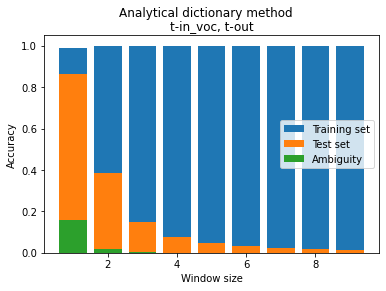

      train      test  ambiguity    size  unique
1  0.987157  0.864758   0.158454  298105   52211
2  0.997777  0.383457   0.017137  296312  200699
3  0.999631  0.149703   0.001860  294582  260092
4  0.999878  0.075545   0.000379  292893  275879
5  0.999936  0.046514   0.000206  291238  280877
6  0.999956  0.032341   0.000142  289619  282643
7  0.999975  0.024036   0.000073  288034  282986
8  0.999985  0.017430   0.000042  286475  282675
9  0.999985  0.013523   0.000035  284935  281965


In [8]:
process_dataset('t-in_voc', 't-out')

#### The five columns in the table show:
1. The accuracy on the training set
2. The accuracy on the test set
3. The ambiguity in the working set
4. The number of windows in the working set
5. The number of unique windows in the working set

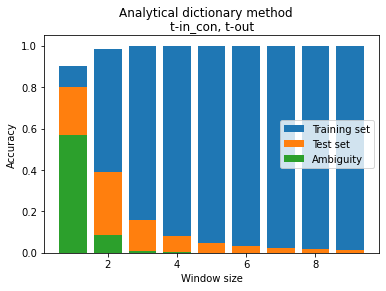

      train      test  ambiguity    size  unique
1  0.899949  0.801380   0.570648  298105   48232
2  0.982938  0.390690   0.084641  296312  196709
3  0.997633  0.156628   0.008785  294582  258469
4  0.999429  0.079062   0.001984  292893  275155
5  0.999750  0.048585   0.000728  291238  280459
6  0.999896  0.032756   0.000394  289619  282360
7  0.999921  0.024187   0.000212  288034  282778
8  0.999960  0.018466   0.000126  286475  282523
9  0.999965  0.014459   0.000098  284935  281845


In [9]:
process_dataset('t-in_con', 't-out')

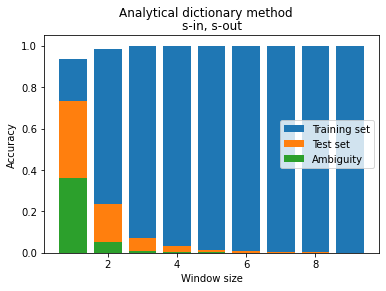

      train      test  ambiguity   size  unique
1  0.934320  0.732742   0.360617  35345   10177
2  0.986379  0.234440   0.049880  35345   28498
3  0.996969  0.072143   0.010355  35345   33360
4  0.998787  0.031498   0.004781  35345   34510
5  0.999515  0.015560   0.001584  35345   34940
6  0.999596  0.008770   0.000792  35345   35139
7  1.000000  0.004338   0.000396  35345   35239
8  0.999879  0.001509   0.000283  35345   35289
9  0.999919  0.001320   0.000170  35345   35316


In [10]:
process_dataset('s-in', 's-out')